# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

# Popularne instancje QAP wraz z dokładnym minimum funkcji celu
   Nug12   12    578 (OPT)    (12,7,9,3,4,8,11,1,5,6,10,2)                 
   Nug14   14   1014 (OPT)    (9,8,13,2,1,11,7,14,3,4,12,5,6,10)            
   Nug15   15   1150 (OPT)    (1,2,13,8,9,4,3,14,7,11,10,15,6,5,12)          
   Nug16a  16   1610 (OPT)    (9,14,2,15,16,3,10,12,8,11,6,5,7,1,4,13)      
   Nug16b  16   1240 (OPT)    (16,12,13,8,4,2,9,11,15,10,7,3,14,6,1,5)       
   Nug17   17   1732 (OPT)    (16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5)       
   Nug18   18   1930 (OPT)    (10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16)     
   Nug20   20   2570 (OPT)    (18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6)
   Nug21   21   2438 (OPT)    (4,21,3,9,13,2,5,14,18,11,16,10,6,15,20,19,8,7,1,12,17) 
   Nug22   22   3596 (OPT)    (2,21,9,10,7,3,1,19,8,20,17,5,13,6,12,16,11,22,18,14,15) 
   Nug24   24   3488 (OPT)    (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2)
   Nug25   25   3744 (OPT)    (5,11,20,15,22,2,25,8,9,1,18,16,3,6,19,24,21,14,7,10,17,12,4,23,13)
*  Nug27   27   5234 (OPT)    (23,18,3,1,27,17,5,12,7,15,4,26,8,19,20,2,24,21,14,10,9,13,22,25,6,16,11)
*  Nug28   28   5166 (OPT)    (18,21,9,1,28,20,11,3,13,12,10,19,14,22,15,2,25,16,4,23,7,17,24,26,5,27,8,6)
*  Nug30   30   6124 (OPT)    (5 12 6 13 2 21 26 24 10 9 29 28 17 1 8 7 19 25 23 22 11 16 30 4 15 18 27 3 14 20)   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [2]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'

## Reading input data

In [3]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [2]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [5]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [6]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

69.83031272888184
600.0 [ 0  2  1  9 11  8 10  5  3  7  6  4]


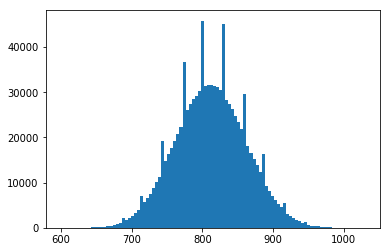

811.933584 49.70040922281167


In [7]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [3]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [9]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

45.28400015830994 578.0


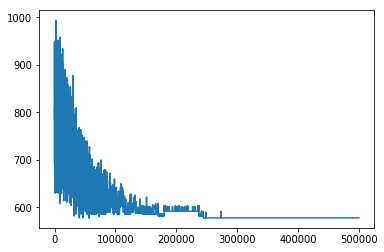

In [10]:
plt.figure()
plt.plot(costs)
plt.show()

### Nug 14

In [9]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug14.dat'
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

80.56403827667236
1068.0 [ 1 12 10  8 11  0 13  7  5  4  3  2  6  9]


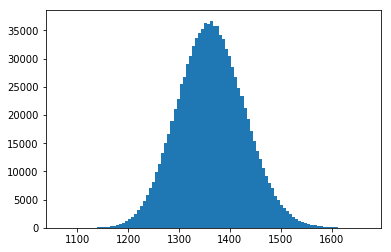

1363.501784 65.74277606564348


In [10]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

In [13]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

50.78299927711487 1014.0


### Nug 18

In [5]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug18.dat'
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 18
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1.]


99.03903579711914
2122.0 [ 9  5  4  1 12  0 11  6 13  8  2 17 10  3 15 16  7 14]


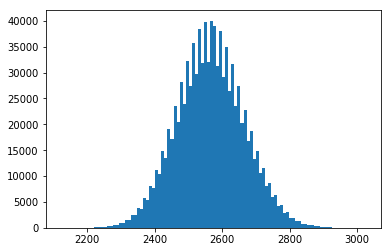

2565.32704 99.06585270837984


In [15]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

In [16]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

62.71399927139282 1930.0


### SA results histogram (Nug 18)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
5945.473542690277


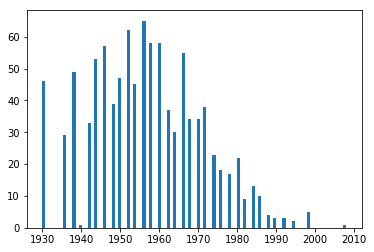

1956.828 14.184301745239347


In [20]:
def SA(T = 500000, radius = 1, alpha = 1.0, verbose=False):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    
    if verbose:
        print(time.time() - t0, costs.min())
    return costs.min()



t0 = time.time()
T = 1000
costs = np.zeros(T)
for i in range(T):
    if i % 100 == 0:
        print(f'{i * 100. / T}%')
    costs[i] = SA(T = 50000)
t1 = time.time()
print(t1 - t0)

plt.figure()
plt.hist(costs, bins=100)
plt.show()
print(costs.mean(), costs.std())  

5.22499942779541 1958.0


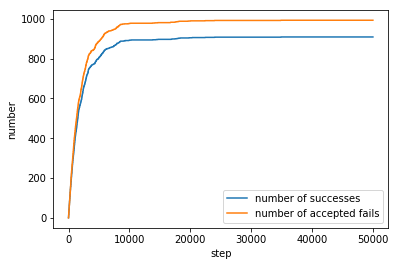

In [14]:
T = 50000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
succs = []
acc_fails = []
succs_cnt = 0
acc_fails_cnt = 0
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
        succs_cnt += 1
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
        acc_fails_cnt += 1
    costs[t] = p_cost
    succs += [succs_cnt]
    acc_fails += [acc_fails_cnt]

print(time.time() - t0, costs.min())
plt.plot(np.arange(T), succs, label='number of successes')
plt.plot(np.arange(T), acc_fails, label='number of accepted fails')
plt.xlabel('step')
plt.ylabel('number')
plt.legend()

5.692036867141724 1996.0


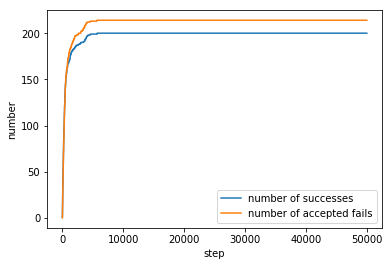

In [16]:
T = 50000
radius = 1
alpha = 5.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
succs = []
acc_fails = []
succs_cnt = 0
acc_fails_cnt = 0
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
        succs_cnt += 1
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
        acc_fails_cnt += 1
    costs[t] = p_cost
    succs += [succs_cnt]
    acc_fails += [acc_fails_cnt]

print(time.time() - t0, costs.min())
plt.plot(np.arange(T), succs, label='number of successes')
plt.plot(np.arange(T), acc_fails, label='number of accepted fails')
plt.xlabel('step')
plt.ylabel('number')
plt.legend()

9.577999114990234 2036.0


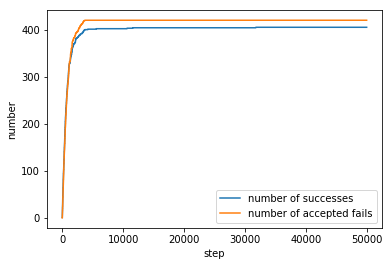

In [18]:
T = 50000
radius = 5
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
succs = []
acc_fails = []
succs_cnt = 0
acc_fails_cnt = 0
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
        succs_cnt += 1
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
        acc_fails_cnt += 1
    costs[t] = p_cost
    succs += [succs_cnt]
    acc_fails += [acc_fails_cnt]

print(time.time() - t0, costs.min())
plt.plot(np.arange(T), succs, label='number of successes')
plt.plot(np.arange(T), acc_fails, label='number of accepted fails')
plt.xlabel('step')
plt.ylabel('number')
plt.legend()

1
2
3
4
5
6
7
8
9
10


No handles with labels found to put in legend.


99.42974472045898 2134.0


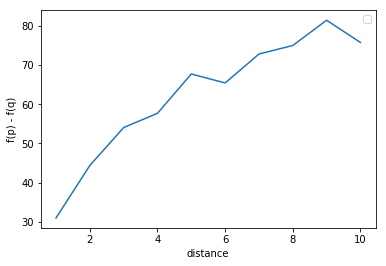

In [30]:
T = 50000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
loss_deltas = []
for radius in range(1, 11):
    loss_deltas_curr = []
    print(radius)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            loss_deltas_curr += [p_cost - q_cost]
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    loss_deltas += [np.array(loss_deltas_curr).mean()]

print(time.time() - t0, costs.min())
plt.plot(np.arange(1, 11), loss_deltas)
plt.xlabel('distance')
plt.ylabel('f(p) - f(q)')
plt.legend()

In [21]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

52.78100299835205 1930.0


1
2
3
4
5
6
7
8
9
10


No handles with labels found to put in legend.


97.14180636405945 2146.0


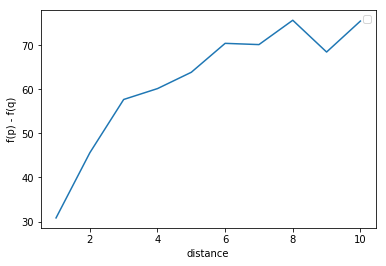

In [6]:
T = 50000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
loss_deltas = []
for radius in range(1, 11):
    loss_deltas_curr = []
    print(radius)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            loss_deltas_curr += [p_cost - q_cost]
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    loss_deltas += [np.array(loss_deltas_curr).mean()]

print(time.time() - t0, costs.min())
plt.plot(np.arange(1, 11), loss_deltas)
plt.xlabel('distance')
plt.ylabel('f(p) - f(q)')
plt.legend()

### e

No handles with labels found to put in legend.


57.619003772735596 1944.0


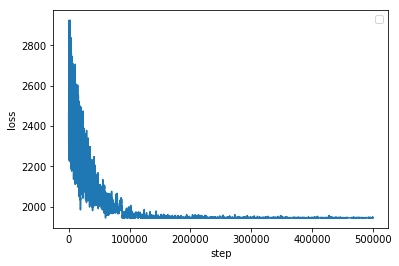

In [11]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())
plt.plot(np.arange(T), costs)
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()

No handles with labels found to put in legend.


61.85703468322754 1942.0


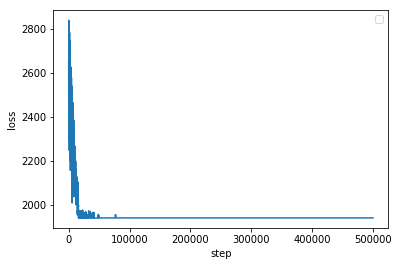

In [17]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
        alpha += 0.001
    costs[t] = p_cost

print(time.time() - t0, costs.min())
plt.plot(np.arange(T), costs)
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()